# Fitting a 3D hyperplane with pymc3

## or...

# Is there dependency between the mass-metallicity relation and the metallicity gradients of galaxies?

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import pymc3 as pm
import theano
from theano import tensor as T

from matplotlib import rc
rc('text', usetex=True)
import matplotlib.pyplot as plt
#import seaborn as sns

## Load data from 65 galaxies
For which their we know their:
 - Stellar mass `logM`
 - Metallicity (oxygen abundance) at the galaxy centre `logZ0`
 - Metallicity gradient (change as metallicity with increasing distance from galaxy centre) `dlogZ`
 - Redshift ("distance" between us and galaxy)  `redshift`
 

In [2]:
data = pd.read_csv('data.csv', index_col=0)
data

,Name,redshift,radius,inc,logM,logM_var,logSFR,logSFR_var,logZ0,dlogZ,logZ0_var,dlogZ_var,logZ0_dlogZ_var,grad_type
0,HDFS_0003,0.563749,0.663518,16.000000,9.747,0.018906,1.386483,0.071249,0.212220,-0.135916,0.000279,0.000086,-0.000052,negative
1,HDFS_0006,0.422325,0.465900,29.000000,9.397,0.021025,-0.017229,0.086854,-0.204761,0.004002,0.018403,0.000249,-0.000552,flat
2,HDFS_0007,0.463676,0.443204,41.000000,9.492,0.051756,0.192963,0.111771,0.678866,-0.344390,0.000252,0.000342,-0.000170,negative
3,HDFS_0008,0.577241,0.183507,61.000000,9.997,0.017292,1.122131,0.078139,0.366301,-0.070069,0.001353,0.000288,-0.000497,negative
4,HDFS_0009,0.563846,0.247173,61.000000,9.487,0.030625,0.958451,0.082691,0.450771,-0.199193,0.000546,0.000231,-0.000235,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,CDFS_11707029,0.522861,0.080843,47.015891,8.147,0.002756,0.098960,0.121107,-0.486894,0.012546,0.034148,0.006845,-0.013452,flat
61,CDFS_11801006,0.336334,0.282977,53.439970,8.597,0.003906,-0.481246,0.001162,-0.252849,-0.003739,0.008708,0.002341,-0.003780,flat
62,CDFS_11803015,0.213611,0.498733,52.522792,8.647,0.004556,-0.966895,0.005474,-0.176921,0.016527,0.019628,0.016429,-0.015855,flat
63,CDFS_11811046,0.576821,0.953135,32.202453,10.540,0.004900,1.279584,0.213249,0.653090,-0.239508,0.000492,0.000375,-0.000261,negative


Additionally, we have variances for the stellar mass `logZ_var`

Since the central metallicity and metallicity gradient are correlated we have correlated uncertainties, where the covariance matrix is defined
$$ \Sigma = \begin{bmatrix}\texttt{logZ0_var} & \texttt{logZ0_dlogZ_var} \\ \texttt{logZ0_dlogZ_var} & \texttt{dlogZ_var}\end{bmatrix} $$

The uncertainty redshift is small enought to be neglected.

## A quick look at the data

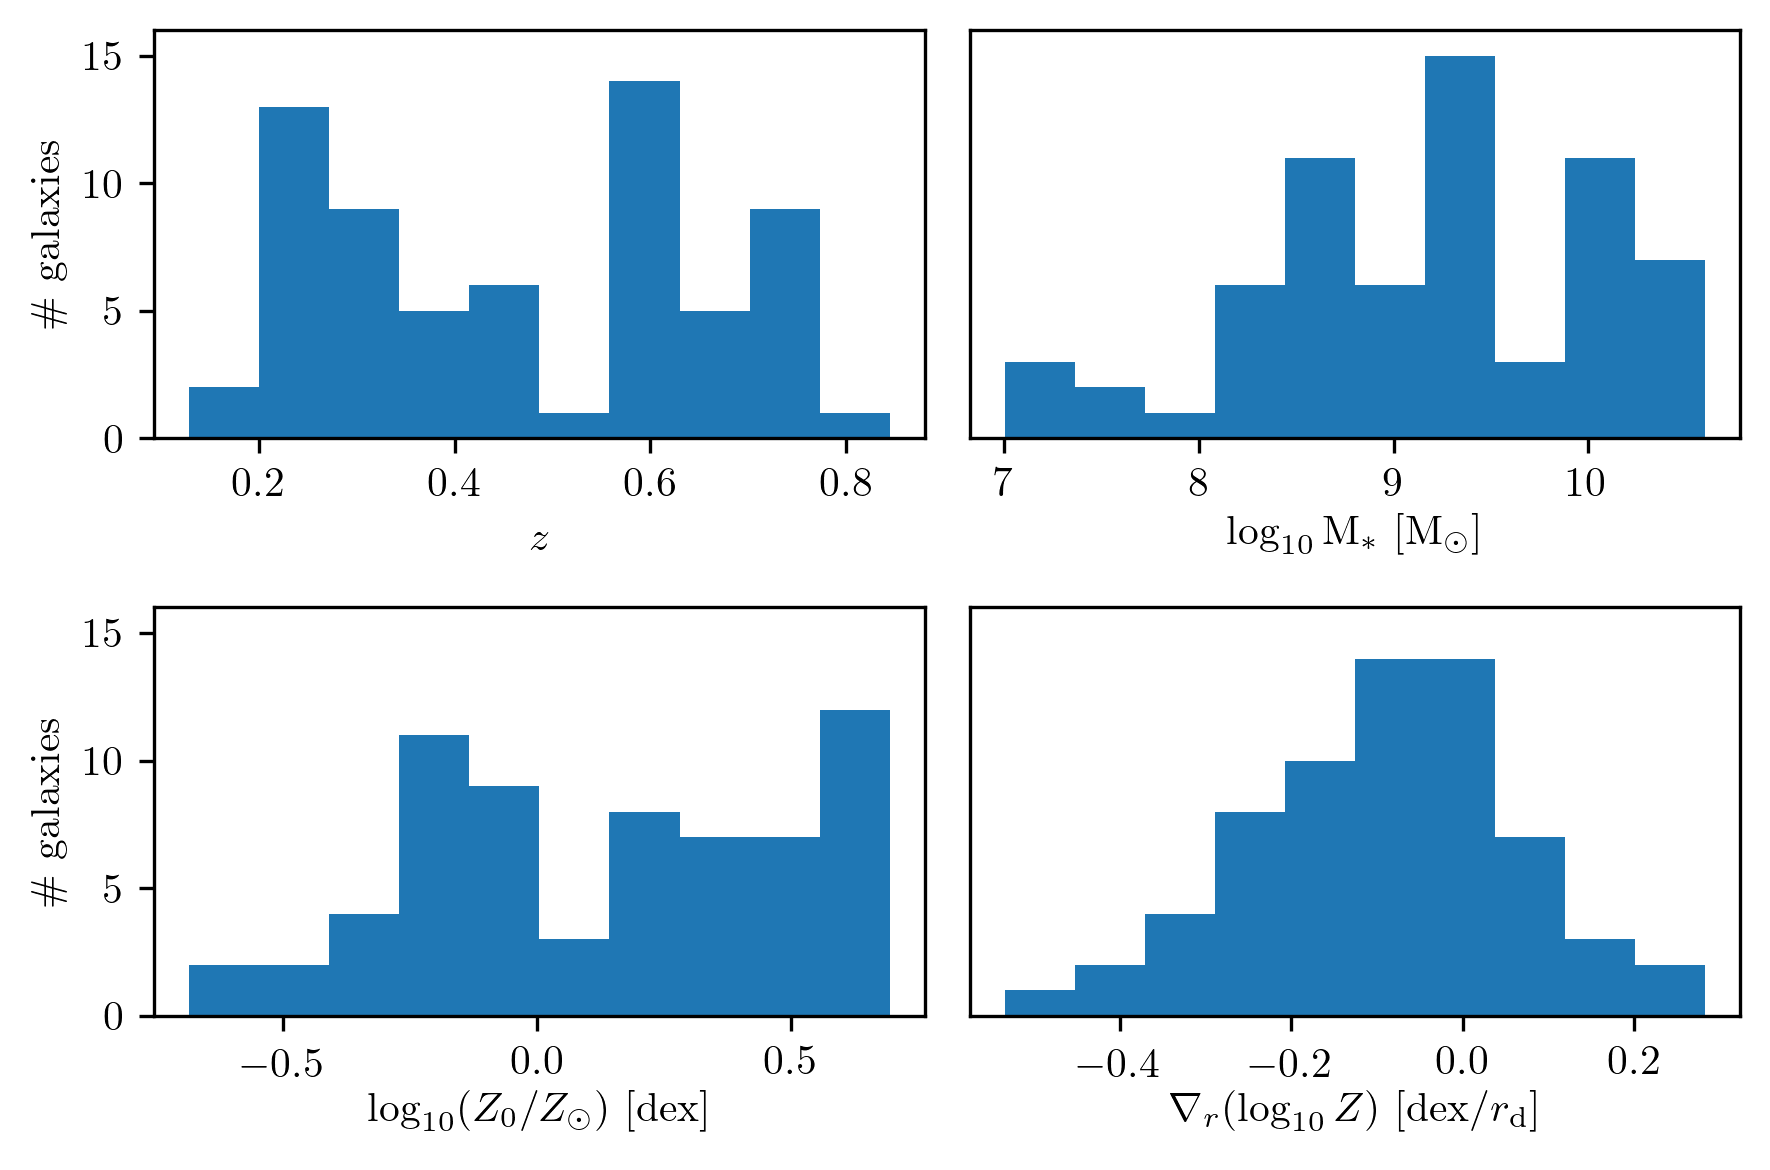

In [3]:
fig, axes = plt.subplots(2, 2, figsize=(6,4), dpi=300, tight_layout=True)
axes = np.array(axes).flatten()

quantities = ['redshift', 'logM', 'logZ0', 'dlogZ']
for ax, quant in zip(axes, quantities):
    ax.hist(data[quant])
    ax.set_ylim(0,16)
    
for ax in axes[0::2]:
    ax.set_ylabel(r'$\textrm{\# galaxies}$')
for ax in axes[1::2]:
    ax.tick_params(left=False, labelleft=False)
axes[0].set_xlabel(r'$z$')
axes[1].set_xlabel(r'$\log_{10}{\rm M}_\ast\ [{\rm M}_\odot]$')
axes[2].set_xlabel(r"$\log_{10}(Z_0/Z_\odot)\ [{\rm dex}]$")
axes[3].set_xlabel(r"$\nabla_r(\log_{10}Z)\ [{\rm dex}/r_{\rm d}]$")
plt.show()

## Do we find the mass metallicity relation

From numerous studies, we know that the central metallicity $\left(\log_{10}Z_0\right)$ is correlated with the stellar mass $\left(\log_{10}{\rm M_\ast}\right)$

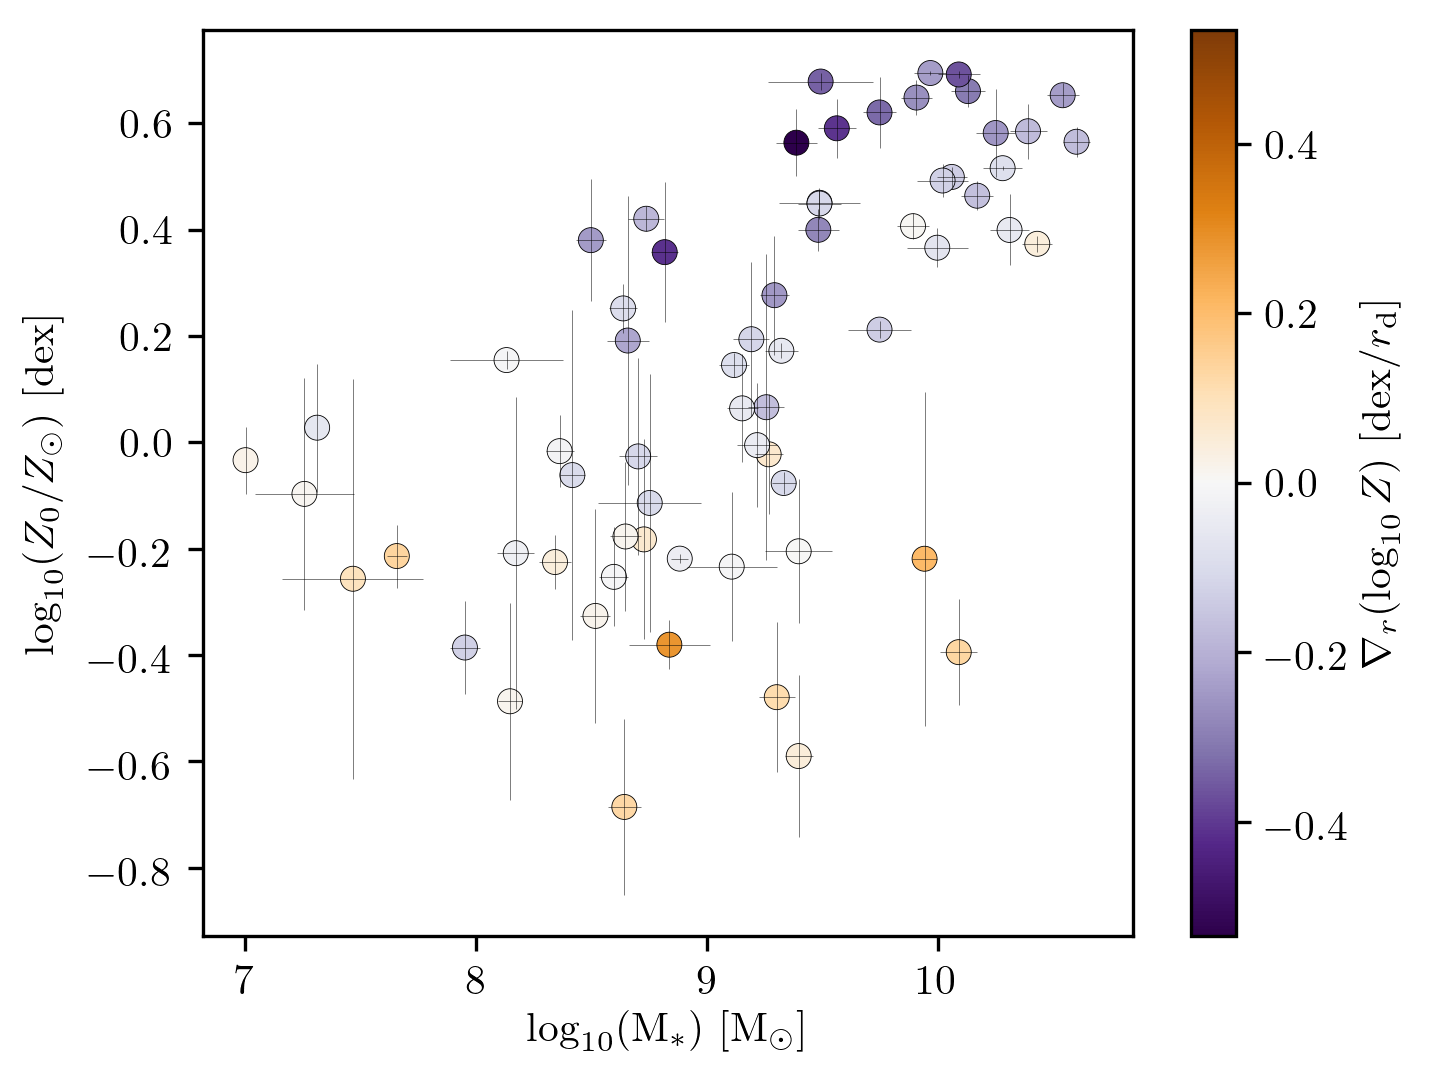

In [4]:
fig, ax = plt.subplots(figsize=(5,4), dpi=300)

#symetric colorbar
vmax = np.max(np.abs(data['dlogZ']))
s = ax.scatter(data['logM'], data['logZ0'], c=data['dlogZ'],
               vmin=-vmax, vmax=vmax, cmap='PuOr_r', ec='k', lw=0.2)
ebar = ax.errorbar(data['logM'], data['logZ0'],
                   xerr=np.sqrt(data['logM_var']), yerr=np.sqrt(data['logZ0_var']),
                   capsize=0, ls='', c='k', lw=0.2, alpha=.6)
cbar = plt.colorbar(s, ax=ax)

ax.set_xlabel(r"$\log_{10}({\rm M}_\ast)\ [{\rm M}_\odot]$")
ax.set_ylabel(r"$\log_{10}(Z_0/Z_\odot)\ [{\rm dex}]$")
cbar.ax.set_ylabel(r"$\nabla_r(\log_{10}Z)\ [{\rm dex}/r_{\rm d}]$")

plt.show()

Indeed, we observe a correlation been $\left(\log_{10}{\rm M_\ast}\right)$ and $\left(\log_{10}Z_0\right)$.
However, this is perhaps weaker than we might have expected from other studies of nearer by galaxies.

We can see that the scatter seems to be partially explained by the metallicity gradient, $\left(\nabla_r(\log_{10}Z)\right)$
At a fixed stellar mass, galaxies with lower central metallicities, have more postive metallicity gradients.

This needs to be explored in more detail.

## The challenge

While we observe that $\log_{10}Z_0$ and $\nabla_r(\log_{10}Z)$ are anti-correlated, these are not independently measured quantities, and their uncertainties are correlated (there are non-zero co-variance terms).

As for a simple straight line fit to the data $y = m x + c$, the error in the intercept $c$ is correlated with the error in the gradient $m$.

Therefore we wish find a plane that descibes the four quantities (stellar mass, central metallicity, metallicity gradient and redshift), and accounts for the correlated errors.

## Hierarchical modelling

We adopt following functional form to describe central metallicity of the $i^{\rm th}$ galaxy

$$\log_{10}Z_{0,i} = \alpha + \beta\, \left(\log_{10}\textrm{M}_{\ast,i} - 9\right) + \gamma\,\, \nabla_r\left(\log_{10}Z\right)_{i} + \frac{\delta}{1 + z_i},$$

where $\alpha$, $\beta$, $\gamma$ and $\delta$ are coefficients to be fit, and $z_i$ is the measured redshift.

The Bayesian hierarchical model can be drawn as follows:

<img src="hierarch_model_fig.svg"  width=500/>

Note that $\log_{10}\textrm{M}_{\ast,i}$ and $\nabla_r\left(\log_{10}Z\right)_{i}$ are _latent_ variables in the model. From these $\log_{10}Z_{0,i}$ can be determined.

However, they do impact upon the likelihood:
$$P\left(y_i \vert \log_{10}\textrm{M}_{\ast,i}, \log_{10}Z_{0,i}, \nabla_r\left(\log_{10}Z\right)_{i}\right) = \mathcal{N}\left(\mu_i,\Sigma_i\right),$$
where $\mu_i$ is the mean vector
$$\mu_i = \begin{bmatrix}
\log_{10}\textrm{M}_{\ast,i} & \log_{10}Z_{0,i} & \nabla_r\left(\log_{10}Z\right)_{i}
\end{bmatrix},$$
and $\Sigma_i$ the covariance matrix
$$\Sigma_i = \begin{bmatrix}
\sigma^2_{i,\textrm{M}_{\ast}} + \sigma^2_{\mathrm{add},\textrm{M}_{\ast}}& 0 & 0 \\
0 & \sigma^2_{i,Z_0} + \sigma^2_{\mathrm{add},Z_0}& \mathrm{cov}_i(Z_0,\nabla_r Z) \\
0 & \mathrm{cov}_i(Z_0,\nabla_r Z)& \sigma^2_{i,\nabla_r Z} + \sigma^2_{\mathrm{add},\nabla_r Z}
\end{bmatrix}.$$

We include additional variance terms $\sigma^2_{\rm add}$ to allow for extra uncertainty and add robustness to the fit.

## Creating the model

In [5]:
model = pm.Model()

### The data

Create the 2D matrix $\mu$,

3D covariance tensor $\Sigma$,

and $z$

In [6]:
n_obs = len(data)

#mu
data_mean = np.full([n_obs, 3], np.nan, dtype=float)
data_mean[:,0] = data['logM'] - 9. #subtract 9, see formula
data_mean[:,1] = data['logZ0']
data_mean[:,2] = data['dlogZ']

#sigma
data_cov = np.zeros([n_obs, 3, 3], dtype=float)
#diagonal terms
data_cov[:,0,0] = data['logM_var']
data_cov[:,1,1] = data['logZ0_var']
data_cov[:,2,2] = data['dlogZ_var']
#covariance terms
data_cov[:,1,2] = data['logZ0_dlogZ_var']
data_cov[:,2,1] = data['logZ0_dlogZ_var']

#redshift 
z = data['redshift']

### Setup priors on coefficients

Use broad uniform priors
- $\alpha \sim \mathit{U}(-5, 5)$
- $\beta \sim \mathit{U}(-5, 5)$
- $\gamma \sim \mathit{U}(-5, 5)$
- $\delta \sim \mathit{U}(-5, 5)$


In [7]:
with model:
    alpha = pm.Uniform('alpha', -5, +5.)
    beta = pm.Uniform('beta', -5, +5.)
    gamma = pm.Uniform('gamma', -5, +5.)
    delta = pm.Uniform('delta', -5, +5.)

### Priors on latent variables of the "true" mass and gradient

- $\log_{10}\textrm{M}_{\ast,i} \sim \mathit{U}(-2.5, 2.5)$
- $\nabla_r\left(\log_{10}Z\right)_{i} \sim \mathit{U}(-0.6, 0.6)$

In [8]:
with model:
    mass = pm.Uniform('mass', -2.5, 2.5, shape=n_obs)
    dlogZ = pm.Uniform('dlogZ', -0.6, +0.6, shape=n_obs)

### Deterministic quantity central metallicity
$$\log_{10}Z_{0,i} = \alpha + \beta\, \left(\log_{10}\textrm{M}_{\ast,i} - 9\right) + \gamma\,\, \nabla_r\left(\log_{10}Z\right)_{i} + \frac{\delta}{1 + z_i},$$

In [9]:
with model:
    logZ0 = alpha + beta * mass + gamma * dlogZ + delta / (1.+z)

### $\mu$ from the model

In [10]:
with model:
    mu = T.stack([mass, logZ0, dlogZ]).T

### Priors on additional uncertainty terms

- $\sigma^2_{{\rm add,M}_\ast} \sim \mathit{U}(0, 50)$
- $\sigma^2_{{\rm add,}\log_{10}Z_0} \sim \mathit{U}(0, 20)$
- $\sigma^2_{{\rm add},\nabla_r(log_{10}Z)} \sim \mathit{U}(0, 12)$

In [11]:
with model:
    mass_var = pm.Uniform('mass_var', 0., 50.)
    logZ0_var = pm.Uniform('logZ0_var', 0., 20.)
    dlogZ_var = pm.Uniform('dlogZ_var', 0., 12.)

### Combine the additional terms to create a covariance matrix of only the additional terms

In [12]:
with model:
    var_extra = T.stack([mass_var, logZ0_var, dlogZ_var])
    cov_extra = T.nlinalg.diag(var_extra)

### Create multinormal log-likelihood function

In [13]:
#compile numpy matrix inverse and determinate functions for theano
@theano.compile.ops.as_op(itypes=[T.dtensor3], otypes=[T.dtensor3])
def np_inv(a):
    return np.linalg.inv(a)

@theano.compile.ops.as_op(itypes=[T.dtensor3], otypes=[T.dvector])
def np_det(a):
    return np.linalg.det(a)


def loglike(mu_data, mu_model, cov_data, cov_extra):
    n_obs, k = mu_data.shape

    #sum data covariance and additional convariances
    cov_extra = T.tile(cov_extra.reshape([1, k, k]), [n_obs, 1, 1])
    cov = cov_data + cov_extra
    
    #matrix inverse convarince matrix
    tau = np_inv(cov)

    #residual
    delta = mu_data - mu_model

    #compute multinomal likelihood for delta and cov in an efficient way
    delta1 = delta.reshape([n_obs, 1, k])
    delta2 = delta.reshape([n_obs, k, 1])
    result = k * T.log(2 * np.pi) + T.log(1./np_det(tau))
    exponent = T.batched_dot(delta1, T.batched_dot(tau, delta2))
    result += T.squeeze(exponent)
    
    return -1/2. * result

In [14]:
with model:
    observed = {'mu_data':data_mean,
                'mu_model':mu,
                'cov_data':data_cov,
                'cov_extra':cov_extra}
    like = pm.DensityDist('loglike', loglike, observed=observed)

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


### Run the MCMC sampling

In [15]:
with model:
    trace = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [dlogZ, mass, delta, gamma, beta, alpha]
>CompoundStep
>>Slice: [dlogZ_var]
>>Slice: [logZ0_var]
>>Slice: [mass_var]
Sampling 2 chains: 100%|██████████| 21000/21000 [16:47<00:00, 20.85draws/s]
There were 1486 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3749 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5482465420027228, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


### The results

In [16]:
pm.summary(trace).loc[['alpha', 'beta', 'gamma', 'delta', 'mass_var', 'logZ0_var', 'dlogZ_var']]

/home/carton/.pyenv/versions/muse/lib/python3.7/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,-0.519127,0.219720,0.008837,-9.671839e-01,-0.126468,86.838061,1.012011
beta,0.211510,0.032830,0.000868,1.431109e-01,0.275487,913.392546,1.005228
gamma,-1.460535,0.178286,0.007562,-1.825360e+00,-1.150319,66.368746,1.021685
delta,0.701713,0.300544,0.011064,1.412731e-01,1.316619,131.546749,1.008256
mass_var,0.203265,0.154809,0.009040,9.105581e-05,0.499278,146.381749,1.000172
logZ0_var,0.012261,0.009869,0.000586,1.131243e-06,0.031020,46.802501,1.011505
dlogZ_var,0.006957,0.005305,0.000355,7.226874e-07,0.016950,28.928445,1.025669


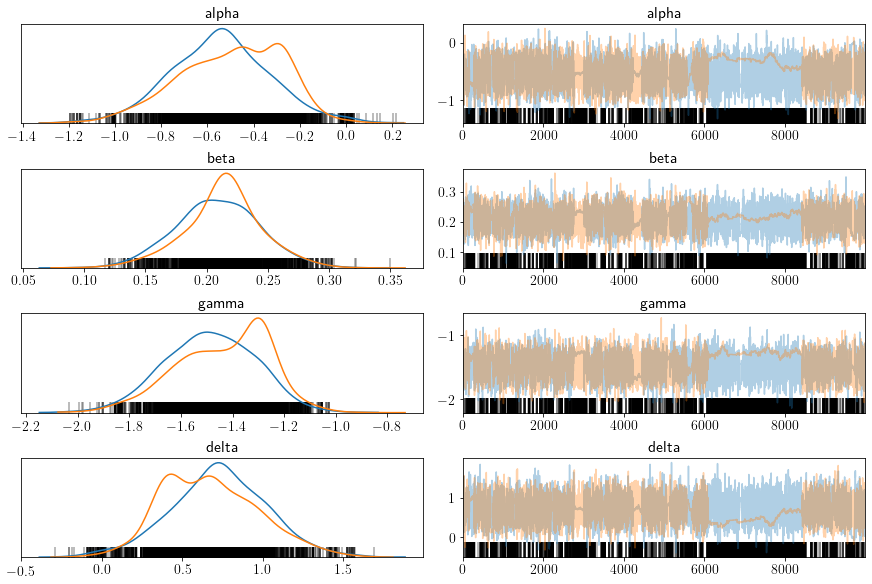

In [21]:
pm.traceplot(trace, var_names=['alpha', 'beta', 'gamma', 'delta']);

There is some degeneracy between $\alpha$ and $\delta$, this is presumably because the redshift ($z$) of a galaxy, does not strongly impact upon the other parameters.

### Get the average model values for $\alpha$, $\beta$, $\gamma$ and $\delta$

In [18]:
fit_alpha = np.median(trace.get_values('alpha'))
fit_beta = np.median(trace.get_values('beta'))
fit_gamma = np.median(trace.get_values('gamma'))
fit_delta = np.median(trace.get_values('delta'))

## Plot two projections of the space, including the model fit

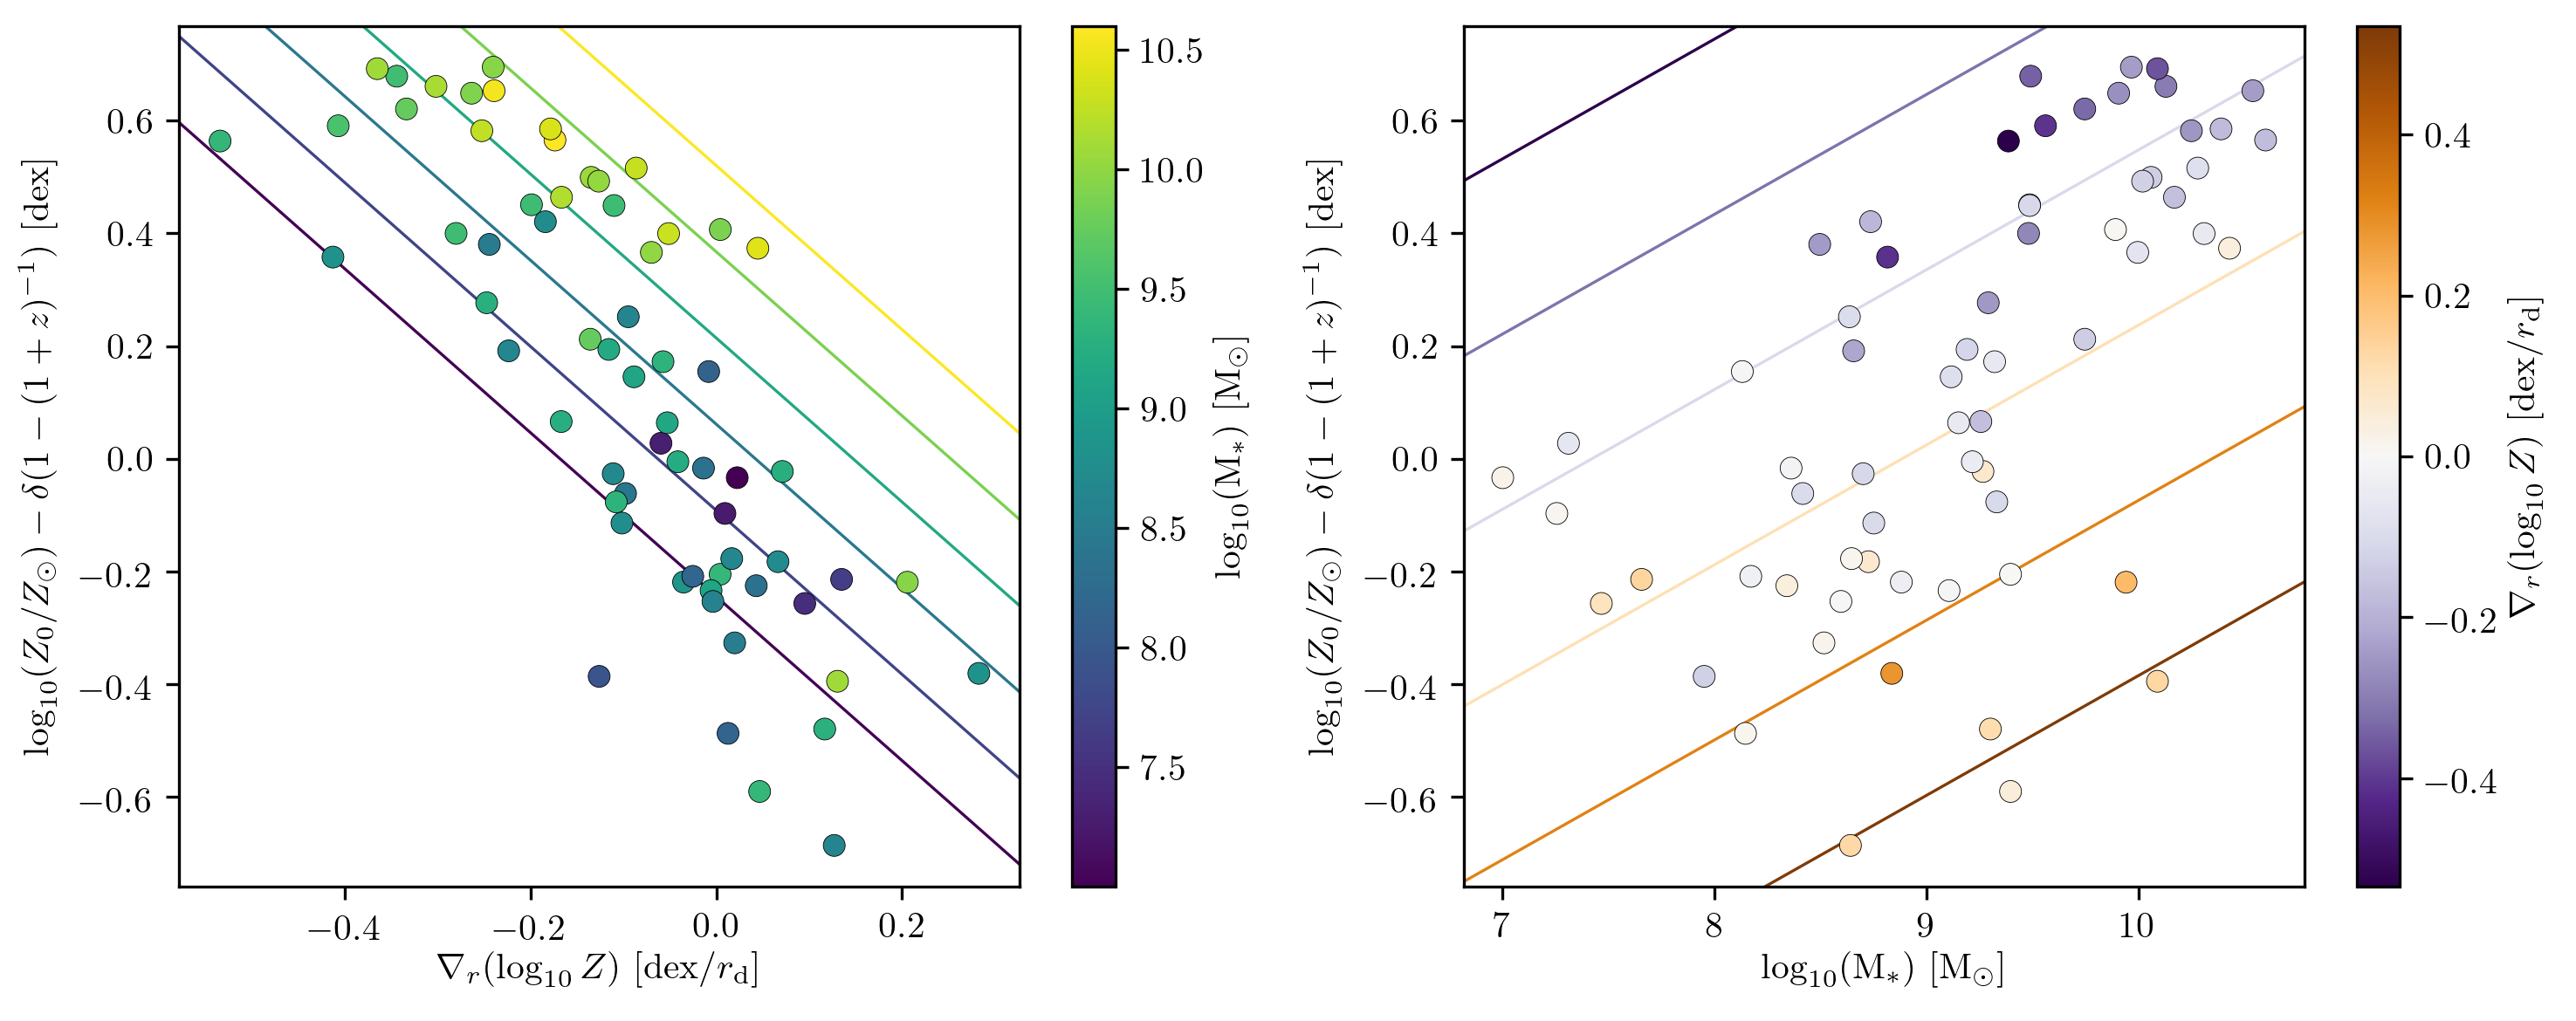

In [19]:
def plot_model_fit(ax, sm, param):
    xlim = np.array(ax.get_xlim())
    ylim = np.array(ax.get_ylim())
    clim = np.array(sm.get_clim())
    plot_x = np.linspace(xlim[0], xlim[1], 100)
    for plot_z in np.linspace(clim[0], clim[1], 6):
        if param == 'logM':
            dlogZ = plot_x
            mass = plot_z
        elif param == 'dlogZ':
            mass = plot_x
            dlogZ = plot_z
        color = sm.to_rgba(plot_z)
        plot_y = fit_alpha + fit_beta * (mass-9.) + fit_gamma * dlogZ + fit_delta/(1.+0.)
        ax.plot(plot_x, plot_y, c=color, zorder=-2, lw=0.8)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4), dpi=300, tight_layout=True)

s = ax1.scatter(data['dlogZ'], data['logZ0'], c=data['logM'], ec='k', lw=0.2)
plot_model_fit(ax1, s, 'logM')
cbar1 = plt.colorbar(s, ax=ax1)

ax1.set_xlabel(r"$\nabla_r(\log_{10}Z)\ [{\rm dex}/r_{\rm d}]$")
ax1.set_ylabel(r"$\log_{10}(Z_0/Z_\odot) - \delta (1 - (1+z)^{-1})\ [{\rm dex}]$")
cbar1.ax.set_ylabel(r"$\log_{10}({\rm M}_\ast)\ [{\rm M}_\odot]$")

#symetric colorbar
vmax = np.max(np.abs(data['dlogZ']))
s = ax2.scatter(data['logM'], data['logZ0'], c=data['dlogZ'],
               vmin=-vmax, vmax=vmax, cmap='PuOr_r', ec='k', lw=0.2)
plot_model_fit(ax2, s, 'dlogZ')
cbar2 = plt.colorbar(s, ax=ax2)

ax2.set_xlabel(r"$\log_{10}({\rm M}_\ast)\ [{\rm M}_\odot]$")
ax2.set_ylabel(r"$\log_{10}(Z_0/Z_\odot) - \delta (1 - (1+z)^{-1})\ [{\rm dex}]$")
cbar2.ax.set_ylabel(r"$\nabla_r(\log_{10}Z)\ [{\rm dex}/r_{\rm d}]$")

plt.show()

Although not perfect, the model provides a reasonable description of the data, which indicates that the correlation is not driven entirely by correlated uncertainties.